# Equilibrium chain-size measuresm

## Importing packages

['../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-all-rPhi-NormalizedScaled.parquet.brotli', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-bug-equilProps-ensAvg.csv', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-wallTimeStat.csv', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-bug-pairDistStats.parquet.brotli', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-all-rRho-NormalizedScaled.parquet.brotli', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-bug-clustersHistFoci.parquet.brotli', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-thermo.parquet.brotli', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-stamps-ens.csv', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-stamps-ensAvg.csv', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-bug-pairDistT.parquet.brotli', '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-runStat.csv', '../../Datasets/TransFociCu

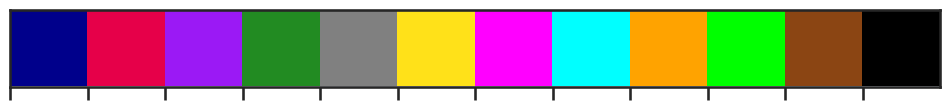

In [23]:
# Importing necessary packages:

from glob import glob
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from polyphys.visualize import plotter
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize import tuner
from polyphys.manage.parser import \
    SumRuleCyl, TransFociCyl, TransFociCub, HnsCub
from polyphys.manage import organizer
from polyphys.analyze import measurer
from polyphys.manage import utilizer

# Project details
#project = 'HnsCub'
#project = 'TransFociCyl'
#project = 'SumRuleCyl'
project = 'TransFociCub'
dmon_large_c_palette = ['orange', 'darkgoldenrod', 'forestgreen']
sns.palplot(AC)
phase = 'ensAvg'
# loading databases:
#allInOne_db = '/Users/amirhsi/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets'
allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
space_dbs = glob(allInOne_db + "allInOne*")
print(space_dbs)

In [ ]:
flar_cmap = mpl.colors.ListedColormap(sns.cm._flare_lut)
flare_cmap_cut = tuner.truncated_colormap(flar_cmap,  min_value=.1, max_value=1, ncolors=1000)
mpl.cm.register_cmap("flare_cmap_cut", flare_cmap_cut)

## SumRule

### Importing data

In [ ]:
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var',# 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# add a column for crowder relative size
dmon = 1.0
chainsize_equil['size_ratio'] = chainsize_equil['dcrowd'].apply(lambda x: r"$a_c<a$" if x < dmon else (r"$a_c=a$"  if x==dmon else r"$a_c>a$"))
print("Equilibrium chain size columns:" , chainsize_equil.columns)
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
chainsize_equil = \
    chainsize_equil.loc[
        ~chainsize_equil['phi_c_bulk_round'].isin(phi_c_to_drop),:]
chainsize_equil.reset_index(inplace=True, drop=True)
# selecting 'norm' measures of properties
attributes = PD[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style]
selected_cols = attributes + norm_props
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round(
        (chainsize_melted['dcrowd'] /
         (chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])), 3
)
print("Unique variables: ", chainsize_melted.variable.unique())

### S and Delta are not normed

In [ ]:
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
height = 4
aspect = 1
font_scale = 1
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = AC
save_to = './'
ext = 'pdf'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

In [ ]:
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
ylabel_pad=25

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

col_attr = 'size_ratio'
col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'dcyl'
style_attr_label = style_attr 
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

#size_attr = 'dcrowd'
#size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]
# The three lines below are for transc foci

hue_attr = 'dcrowd'
hue_attr_label = hue_attr + '-' + project
hue_order = sorted(chainsize_melted[hue_attr].unique())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws
)
grid.set_titles('')
grid.set_titles(AL[col_attr] + "{col_name}")
grid.set_xlabels(AL[x_prop])
grid.set(xticks=np.arange(0,0.5,0.1))

for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        PL[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
legend_labels = ([AL[hue_attr_label]] + list(hue_order) +
                 [AL[style_attr_label]] + list(style_order))
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    grid,
    loc='upper left',
    bbox_to_anchor=(0.89, 0.96),
    **legend_kws)
grid.tight_layout(w_pad=0.5,h_pad=0.5)
#grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, 'chainMeasures', norm_style,
                   x_prop, row_attr, hue_attr,style_attr]
                 )
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
#plt.close()

### S and Delta nomred

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'nmon'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'dcyl'
size_order = sorted(chainsize_melted[size_attr].unique())
sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.2,0.2,0.2,0.2]):
    ymin, ymax = ax.get_ylim()
    ymin = utilizer.round_up_nearest(ymin, 0.2, 1)
    ymax = utilizer.round_up_nearest(ymax, 0.2, 1)
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    ax.set_ylim(ymin-0.2*ystep, ymax+0.2*ystep)
    ax.set_title("")
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order) +  \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(grid, loc='upper left', **move_legend_kws)
grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### a_c=a

In [ ]:
dcrowd_cond = (chainsize_melted['dcrowd'].isin([1.0]))
cond = dcrowd_cond
data = chainsize_melted.loc[cond, :].copy()
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

col_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

#style_attr = 'dcyl'
#style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'nmon'
size_order = sorted(data[size_attr].unique())
sizes=[3+2*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcyl'
hue_order = sorted(data[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 2
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=True,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=10,
    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.1,0.2,0.02,0.05]):
    ymin, ymax = ax.get_ylim()
    ymin = utilizer.round_up_nearest(ymin, ystep, 2)
    ymax = utilizer.round_up_nearest(ymax, ystep, 1)
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    ax.set_ylim(ymin-0.5*ystep, ymax+0.5*ystep)
    ax.set_title("")
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    #grid._legend.legendHandles[idx].set_linewidth(7)
    grid._legend.texts[idx].set_ha('left')
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(grid, loc='upper left', **move_legend_kws)
grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures-DcrowdEqualDmon'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

## TransFociCyl

In [ ]:
group = 'bug'
geometry = 'cylindrical'
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, group, 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
chainsize_equil = \
    chainsize_equil.loc[
        ~chainsize_equil['phi_c_bulk_round'].isin(phi_c_to_drop),:]
chainsize_equil.reset_index(inplace=True, drop=True)
# selecting 'norm' measures of properties
attributes = project_details[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
## Style 1: asphericiity adn shape parameter normalized
#norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-norm', 'shapeMon-norm'
#]
#selected_cols = attributes + norm_props
#value_vars = norm_props
## Style 2: asphericiity adn shape parameter not normalized
gyr_fsd_only_norm_props = [
    'gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
]
selected_cols = attributes + gyr_fsd_only_norm_props
value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
# dictionary of normalizer properties' features
project_titles = {}
spaces = chainsize_equil['space'].unique()
for space in spaces:
    s_info = project_details[project]['parser'](
        space,
        'space',
        project_details[project]['geometry'],
        project_details[project]['group'],
        project_details[project]['topology'],
        ispath=False
    )
    project_title_style = {
        #'SumRule': fr" $N={s_info.nmon}, {{D}}/{{a}}={s_info.dcyl}, {{a_c}}/{{a}}={s_info.dcrowd}$",
        'TransFociCyl': fr" $N_m={s_info.nmon_small}, N_M={s_info.nmon_large}, {{D}}/{{a_m}}={s_info.dcyl}, {{a_c}}/{{a_m}}={s_info.dcrowd}$"
        }
    project_titles[project] = project_title_style[project]

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large'
col_attr = 'variable'
col_order = value_vars
col_wrap = 1
save_to = './'
ext = 'pdf'
# The three lines below are for transc foci
color_palette = dmon_large_c_palette
markers=['o', 'o', '^']
dashes=[(2, 2), (2, 2), (1, 0)]
#color_palette = 'colorblind'
plot_context = 'talk'
font_scale = 2
height = 6
aspect = 1.618
ylabel_pad = 50
rc_params = {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
facet_kws = {
        'sharey': False,
        'sharex': True,
        'legend_out': True
        }
fig_title_kws = {'fontsize': 34, 'x': 0.45, 'y': 0.95}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'bbox_to_anchor': (0.21, 0.65),
    'frameon': True,
    'facecolor': 'lightgray',
    'borderpad': 0.1
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    legend='full',
    hue=hue_attr,
    style=hue_attr,
    kind='line',
    dashes=dashes,
    markers=markers,
    height=height,
    aspect=aspect,
    palette=color_palette,
    col_wrap=col_wrap,
    facet_kws=facet_kws,
    markersize=15
)
for ax, prop in zip(grid.axes.flat, col_order):
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_title(None)
axis_ls = grid.axes[1]
vline_patch = tuner.marker_ls_handler(
    ['False', 'True'], ['--', '-'], ['o', '^'],color='black'
)
axis_ls.legend(
    title='Collapse transition',
    handles=vline_patch,
    bbox_to_anchor=(0.67, 0.48),
    frameon=True,
    facecolor='lightgray',
    borderpad=0.1
)
grid.set_xlabels(AL[x_prop])
grid.legend.set_title(AL[hue_attr])
grid.fig.suptitle(project_titles[project], **fig_title_kws)
#grid.tight_layout(w_pad=1)
grid.tight_layout(w_pad=0, h_pad=0.5)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(xticks=np.arange(0,0.5,0.1))
#grid.set(yticks=np.arange(0,1.2,0.2), xticks=np.arange(0,0.5,0.1))
output = "-".join(["equilPlot", project, 'chainMeasures', x_prop, hue_attr])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

## TransFociCub

In [24]:
group = 'bug'
geometry = 'cubic'
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, group, 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
chainsize_equil = \
    chainsize_equil.loc[
        ~chainsize_equil['phi_c_bulk_round'].isin(phi_c_to_drop),:]
chainsize_equil.reset_index(inplace=True, drop=True)
# selecting 'norm' measures of properties
attributes = PD[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
# option 1: norms of asphericityMon-norm and shapeMona
norm_props = [
    'gyrMon-norm', #'asphericityMon-norm', 'shapeMon-norm'
]
selected_cols = attributes + norm_props
value_vars = norm_props
# option 2: means of asphericityMon-norm and shapeMona
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
# dictionary of normalizer properties' features
project_titles = {}
spaces = chainsize_equil['space'].unique()
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    project_title_style = {
        'TransFociCub': fr" $N_m={s_info.nmon_small}, N_M={s_info.nmon_large}, {{a_c}}/{{a_m}}={s_info.dcrowd}$"
        }
    project_titles[project] = project_title_style[project]

In [66]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large'
col_attr = 'variable'
col_order = value_vars
col_wrap = 1
save_to = './'
ext = 'pdf'
# The three lines below are for transc foci
color_palette = dmon_large_c_palette
markers=['o', 'o', '^']
dashes=[(2, 2), (2, 2), (1, 0)]
#color_palette = 'colorblind'
plot_context = 'talk'
font_scale = 1
height = 4
aspect = 1.618
ylabel_pad = 30
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
facet_kws = {
        'sharey': False,
        'sharex': True,
        'legend_out': True
        }
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.88}
loc='lower left'
font_family = 'sans-serif'
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'edgecolor': 'black',
    'markerscale': 1
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    legend='full',
    hue=hue_attr,
    style=hue_attr,
    kind='line',
    dashes=dashes,
    markers=markers,
    height=height,
    aspect=aspect,
    palette=color_palette,
    col_wrap=col_wrap,
    facet_kws=facet_kws,
    markersize=15
)
for ax, prop in zip(grid.axes.flat, col_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_title(project_titles[project])
#axis_ls = grid.axes[1]
#vline_patch = tuner.marker_ls_handler(
#    ['False', 'True'], ['--', '-'], ['o', '^'],color='black'
#)
#axis_ls.legend(
#    title='Collapse transition',
#    handles=vline_patch,
#    bbox_to_anchor=(0.64, 0.53),
#    frameon=True,
#    facecolor='lightgray',
#    borderpad=0.1
#)
grid.set_xlabels(AL[x_prop])
grid.legend.set_title(AL[hue_attr])
#grid.fig.suptitle(project_titles[project], **fig_title_kws)
#grid.tight_layout(w_pad=1)
grid.tight_layout(w_pad=0, h_pad=0.5)
sns.move_legend(grid,
                loc='lower left',
        bbox_to_anchor=(0.2, 0.24),
        **legend_kws)
#grid.set(yticks=np.arange(0,1.2,0.2), xticks=np.arange(0,0.5,0.1))
#grid.set(yticks=np.arange(0.2,1.2,0.2), xticks=np.arange(0,0.5,0.1))
output = "-".join(["equilPlot", project, 'chainMeasures', x_prop, hue_attr])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### single proeprty

## TransFoci Cub and Cyl

In [17]:
phase = 'ensAvg'
norm_props = ['gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean']
projects = ['TransFociCub', 'TransFociCyl']
project_titles = {}
spaces = {}

goem_dict = {
    'cubic': 'Free space',
    'cylindrical': 'Cylindrical confinement'
}
chainsize_trans_foci = []
for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/'
    equil_db = '-'.join(
        ['allInOne', project, PD[project]['group'], 'equilProps',
         phase
        ]
    )
    equil_db = allInOne_db + equil_db + '.csv'
    chainsize_equil = pd.read_csv(equil_db)
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    chainsize_equil = \
        chainsize_equil.loc[
            ~chainsize_equil['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    chainsize_equil.reset_index(inplace=True, drop=True)
    # selecting 'norm' measures of properties
    attributes = PD[project]['equil_attributes']
    # globe size line
    if project == 'TransFociCyl':
        dmon_large_cond = (chainsize_equil['dmon_large'] == 5)
        phi_c_cond = (chainsize_equil['phi_c_bulk_round'] == 0)
        gyr_phic0_dmon_large = chainsize_equil.loc[dmon_large_cond & phi_c_cond, 'gyrMon-mean'].values[0]
        nmon_small = chainsize_equil['nmon_small'].values[0]
        nmon_large = chainsize_equil['nmon_large'].values[0]
        globe_size = (nmon_small + nmon_large) ** (1/3)
        r_globe_ratio = globe_size/gyr_phic0_dmon_large
    #norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
    # option 1: norms of asphericityMon-norm and shapeMona
    selected_cols = attributes + norm_props
    value_vars = norm_props
    # option 2: means of asphericityMon-norm and shapeMona
    #gyr_fsd_only_norm_props = [
    #    'gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
    #]
    #selected_cols = attributes + gyr_fsd_only_norm_props
    #value_vars = gyr_fsd_only_norm_props
# melting properties column
    chainsize_melted = chainsize_equil[selected_cols].melt(
        id_vars=attributes,
        value_vars=value_vars
    )
    chainsize_melted['geometry'] =  goem_dict[PD[project]['geometry']]
    chainsize_trans_foci.append(chainsize_melted)
    # dictionary of normalizer properties' features
    spaces[project] = chainsize_equil['space'].unique()
    for space in spaces[project]:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_m={s_info.nmon_small},$ " +
                fr"$N_M={s_info.nmon_large},$ " +
                fr"${{a_M}}/{{a_m}}={s_info.dmon_large},$ " +
                fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$"
            )
        if project == 'TransFociCub':
            project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                   fr"$N_M={s_info.nmon_large},$ " +
                                   fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
        elif project == 'TransFociCyl':
            project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                   fr"$N_M={s_info.nmon_large},$ " +
                                   fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                                   fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
        else:
            raise ValueError(f"Project: '{project}' is not defined.")

chainsize_trans_foci =  pd.concat(chainsize_trans_foci, axis=0)
chainsize_trans_foci.reset_index(inplace=True, drop=True)
# cubic geometry does not ha've 'dcyl' values
chainsize_trans_foci.fillna('N/A', inplace=True)

In [18]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
style_attr = 'geometry'
style_order = ['Free space', r'Cylindrical confinement ($D/a_m=20$)']

data = chainsize_trans_foci
hue_attr = 'dmon_large'
hue_order = sorted(chainsize_trans_foci[hue_attr].unique())
row_attr = 'variable'
row_order = value_vars
#col_attr = 'dmon_large'
save_to = './'
ext = 'pdf'
# The three lines below are for transc foci
#color_palette = dmon_large_c_palette
markers=['s', 'o']
dashes=[(2, 2), (1, 0)]
# plots settings
color_palette = AC[:3]
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 1.5
height = 5
aspect = 1.5*1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='center right'
font_family = 'sans-serif'
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1,0.8),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2,
    'title': ''
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row = row_attr,
    row_order = row_order,
    style=style_attr,
    style_order=style_order,
    legend='full',
    hue=hue_attr,
    hue_order=hue_order,
    kind='line',
    dashes=dashes,
    markers=markers,
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
    fillstyle='none',
    markeredgecolor=None
)
for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_title(None)
vline_patch = tuner.marker_ls_handler(
    style_order, ['--', '-'], ['s', 'o'], color='black'
)
grid.set_xlabels(AL[x_prop])
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[style_attr]] + list(style_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    grid._legend.legendHandles[idx].set_fillstyle('none')
    grid._legend.legendHandles[idx].set_linewidth(4)
    grid._legend.texts[idx].set_ha('left')
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
grid.tight_layout(w_pad=0, h_pad=0.5)
grid.set(xticks=np.arange(0,0.5,0.1))
#ax_r_globe = grid.axes.flatten()[0]
#globe_line = ax_r_globe.axhline(y=r_globe_ratio,ls='-.',c='black')
#ax_r_globe.legend([globe_line],
#                  [r"$a_M/a_m=5: {R_{globe}}/{R_{g,0}}\sim a_m #(N_m+N_M)^{1/3}/{R_{g,0}}$"],markerscale=1.5,fontsize=18,
#                          **legend_global_kws)
# saving
output = "-".join(["equilPlot-TransFoci-chainMeasures", x_prop, hue_attr])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

In [19]:
height = 9
aspect = 1 * 16/9  # 2 * 1.618 # Golden ratio
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
font_scale = 2
plot_context = 'talk'
save_to = './'
ext = 'pdf'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': True,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 1
}
global_bbox = dict(boxstyle="round,pad=0.2",ec='black',fc='none',linewidth=1.2)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.93, 'ha': 'center'}# only radius of gyration 


x_prop = 'phi_c_bulk_round'
y_prop = 'value'
style_attr = 'geometry'
style_order = ['Free space', 'Cylindrical confinement']

var_cond = (chainsize_trans_foci['variable'] == 'gyrMon-norm')
data = chainsize_trans_foci.loc[var_cond,:]
hue_attr = 'dmon_large'
hue_order = sorted(chainsize_trans_foci[hue_attr].unique())
row_attr = 'variable'
row_order = value_vars
#col_attr = 'dmon_large'

# The three lines below are for transc foci
#color_palette = dmon_large_c_palette
markers=['s', 'o']
dashes=[(2, 2), (1, 0)]
# plots settings
color_palette = AC[:3]

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
fig, ax = plt.subplots(1, 1, figsize=(aspect*height,height))
grid = sns.lineplot(
    data=data,
    x=x_prop,
    y=y_prop,
    style=style_attr,
    style_order=style_order,
    legend='full',
    hue=hue_attr,
    hue_order=hue_order,
    dashes=dashes,
    markers=markers,
    palette=color_palette,
    markersize=15,
    fillstyle='none',
    ax=ax,
    markeredgecolor=None
)

vline_patch = tuner.marker_ls_handler(
    style_order, ['--', '-'], ['s', 'o'], color='black'
)
grid.set_title(projects_comon_title)
grid.set_xlabel(AL[x_prop])
grid.set_ylabel(AL['gyrMon-norm'])

legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[style_attr]] + list(style_order)
                )
grid.legend(
    handles=grid.legend_.legendHandles, 
    labels=legend_labels,
    loc='best',
    **legend_kws)
grid.set(xticks=np.arange(0,0.5,0.1))
grid.set(ylim=(0.1,1.1), yticks=np.arange(0.2,1.2,0.2))
output = "-".join(["gyrMon-TransFoci-chainMeasures", x_prop, hue_attr])
plt.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

## HnsCub

In [4]:
#species = 'Mon'
#allInOne_db = '../../Datasets/' # mac-mini
#allInOne_db = '/Users/amirhsi_mini/research_data/analysis/'
group = 'nucleoid'
geometry = 'cylindrical'
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, group, 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# add a column for crowder relative size
dmon = 1.0
chainsize_equil['size_ratio'] = chainsize_equil['dcrowd'].apply(lambda x: r"$a_c<a$" if x < dmon else (r"$a_c=a$"  if x==dmon else r"$a_c>a$"))
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
chainsize_equil = \
    chainsize_equil.loc[
        ~chainsize_equil['phi_c_bulk_round'].isin(phi_c_to_drop),:]
chainsize_equil.reset_index(inplace=True, drop=True)
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = project_details[project]['equil_attributes']
# option 1: norms of asphericityMon and shapeMon
norm_props = [
    'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm'
]
# option 2: means of asphericityMon and shapeMon
#norm_props = [
#    'gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
# melting properties columns
selected_cols = attributes + norm_props
value_vars = norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)

FileNotFoundError: [Errno 2] No such file or directory: '../../Datasets/TransFociCub-allInOne/allInOne-TransFociCub-nucleoid-equilProps-ensAvg.csv'

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'dcrowd'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

#size_attr = 'nhns'
#size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'nhns'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
#color_palette = 'hls'
color_palette = AC
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 1.5
height = 5
aspect = 1.5*1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='center right'
font_family = 'sans-serif'
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.8,1),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 3,
    'title': ''
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    #size=size_attr,
    #size_order=size_order,
    #sizes=sizes,
    #markers=True,
    markers=['s','o'],
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.2,0.2]):
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_title("")
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
#legend_labels = [AL[hue_attr]] + list(hue_order)  + \
#        [AL[style_attr]] + list(style_order)
#for idx, new_label in enumerate(legend_labels):
#    grid._legend.texts[idx].set_text(new_label)
grid.legend.set_title(AL[hue_attr])
grid.set(xticks=np.arange(0,0.45,0.1),yticks=np.arange(0,1.1,0.2))
if style_attr == 'dcrowd':
    style_attr_name = style_attr + '-' + project
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
        [AL[style_attr_name]] + list(style_order)
grid._legend.set_title('')
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
#sns.move_legend(grid, loc=loc, **move_legend_kws)
#sns.move_legend(grid, loc='upper left', **move_legend_kws)
#sns.move_legend(grid, loc=loc, **move_legend_kws)
#grid.fig.tight_layout(pad=1)
# globe size line
hns_cond = (chainsize_equil['nhns'] == 0)
phi_c_cond = (chainsize_equil['phi_c_bulk_round'] == 0)
dcrowd_cond = (chainsize_equil['dcrowd'] == 2)
gyr_phic0_hns0_ac2 = chainsize_equil.loc[hns_cond & phi_c_cond & dcrowd_cond, 'gyrMon-mean'].values[0]
nmon = chainsize_equil['nmon'].values[0]
globe_size = nmon**(1/3)
globe_line = grid.axes.flatten()[0].axhline(y=globe_size/gyr_phic0_hns0_ac2,ls=':')
grid.axes.flatten()[0].legend([globe_line],
                          [r"${R_{globe}}/{R_{g,0}}=aN^{1/3}/{R_{g,0}}$"],
                          **legend_global_kws)
# saving
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, 'chainMeasures'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()